In [ ]:
%load_ext autoreload
%autoreload 2

In [220]:
import os
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import OpenEXR as exr, Imath
from tqdm import tqdm
from glob import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils.cloud import Cloud
from pose_est import PoseEst, create_rot_from_angle, transform_pc, extrinsics_from_rot_transl
from params_est import optim_step_ICP

In [54]:
ksize = 10
depth_dir = f'../data/synthetic/stylized-ww01-plane/blender_renders_depth4_3x_more_frames_mblur_{ksize}/'
gt_extrinsics_dir = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_/'
gt_depth_dir = '../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_'
shared_K_path = f'../data/synthetic/stylized-ww01-plane/blender_render_depth4_3x_more_frames_/K_0.txt'

In [55]:
K = torch.tensor(np.loadtxt(shared_K_path)).double()

In [56]:
K

tensor([[2.6667e+03, 0.0000e+00, 9.6000e+02],
        [0.0000e+00, 2.6667e+03, 5.4000e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]], dtype=torch.float64)

In [83]:
def load_data(depth_dir, gt_extrinsics_dir, indices, gt_depth_dir=None):
    # indices: array-like of int
    depth_all, RT_all, gt_depth_all = [], [], []
    for ind in indices:
        depth = np.load(os.path.join(depth_dir, f'{ind}.npy'))
        RT = np.loadtxt(os.path.join(gt_extrinsics_dir, f'RT_{ind}.txt'))
        depth_all.append(depth)
        RT_all.append(RT)
        if gt_depth_dir is not None:
            gt_depth = np.load(os.path.join(gt_depth_dir, f'{ind}.npy'))
            if len(gt_depth.shape) == 3 and gt_depth.shape[2] == 1:
                gt_depth = gt_depth[..., 0]
            gt_depth_all.append(gt_depth)
    
    depth_all = torch.tensor(np.stack(depth_all)).double()
    RT_all = torch.tensor(np.stack(RT_all)).double()
    if gt_depth_dir is not None:
        gt_depth_all = torch.tensor(np.stack(gt_depth_all)).double()
        return depth_all, RT_all, gt_depth_all
    return depth_all, RT_all

In [148]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[10, 50], gt_depth_dir=gt_depth_dir)

In [149]:
depth[0].min(), depth[0].max()

(tensor(6.1587, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [150]:
depth[1].min(), depth[1].max()

(tensor(6.2128, dtype=torch.float64), tensor(15., dtype=torch.float64))

In [60]:
depth.shape, extr.shape, gt_depth.shape

(torch.Size([2, 1080, 1920]),
 torch.Size([2, 4, 4]),
 torch.Size([2, 1080, 1920, 1]))

### Testing visualization

In [61]:
pc1 = Cloud.from_tensors(depth[0], K, extr[0], ignore='max')

In [62]:
pc1.points

tensor([[ 0.8195, -0.3742,  7.0272],
        [ 0.7736, -0.3521,  6.6122],
        [ 0.7273, -0.3300,  6.1964],
        ...,
        [ 0.0440,  0.7502,  5.8670],
        [ 0.0525,  0.8521,  6.6635],
        [ 0.0615,  0.9539,  7.4594]], dtype=torch.float64)

In [63]:
pc1.points[:, 2].max()

tensor(7.5268, dtype=torch.float64)

In [77]:
def visualize_pcd(*cloud_objs):
    all_pc_o3d = []
    for cloud in cloud_objs:
        cloud_pts = cloud.points.cpu().data.numpy()
        pc_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(cloud_pts))
        all_pc_o3d.append(pc_o3d)
    o3d.visualization.draw_geometries(all_pc_o3d)

In [78]:
visualize_pcd(pc1)

### Testing params estimation

In [170]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[10, 50], gt_depth_dir=gt_depth_dir)

In [185]:
# pc0 = Cloud.from_tensors(depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(depth[1], K, torch.eye(4), ignore='max')
pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [186]:
visualize_pcd(pc0, pc1)

In [188]:
# optimization step & pc0 update:

params = optim_step_ICP(pc0, pc1, max_iter=100, icp_max_iter=30, verbose=1)
transl, angle = params.split([3, 3], dim=-1)
rot = create_rot_from_angle(angle.unsqueeze(0)).squeeze(0)
pc0.points = transform_pc(pc0.points, rot, transl).squeeze(1)
params

  0%|          | 0/100 [00:00<?, ?it/s]

Correspondence set estimation...
Extrinsics estimation...


  0%|          | 0/100 [00:01<?, ?it/s]


tensor([-1.0645, -0.0400,  0.0527, -0.0089,  0.1371, -0.0186],
       dtype=torch.float64)

In [200]:
visualize_pcd(pc0, pc1)

In [178]:
transl

tensor([-0.0782,  0.0730,  0.0267], dtype=torch.float64)

In [205]:
extrinsics_from_rot_transl(rot, transl)

tensor([[ 0.9904,  0.0179,  0.1368, -1.0645],
        [-0.0191,  0.9998,  0.0076, -0.0400],
        [-0.1366, -0.0101,  0.9906,  0.0527],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

In [199]:
extr[0] @ torch.inverse(extr[1])

tensor([[ 0.9936,  0.0184, -0.1117,  1.1219],
        [-0.0175,  0.9998,  0.0085, -0.0792],
        [ 0.1118, -0.0064,  0.9937, -0.0227],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)

### GradOdometry

In [230]:
depth, extr, gt_depth = load_data(depth_dir, gt_extrinsics_dir, indices=[10, 50], gt_depth_dir=gt_depth_dir)
# depth = depth.requires_grad_()
depth_first = depth[0].clone()
depth_second = depth[1].clone()
_ = depth_first.requires_grad_()

In [231]:
depth.shape

torch.Size([2, 1080, 1920])

In [232]:
pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
# pc0 = Cloud.from_tensors(gt_depth[0], K, torch.eye(4), ignore='max')
# pc1 = Cloud.from_tensors(gt_depth[1], K, torch.eye(4), ignore='max')

In [233]:
visualize_pcd(pc0, pc1)

In [234]:
def loss(T_estim, extr_first, extr_second):
    gt_rel_extr = extr_first @ torch.inverse(extr_second)    # TODO not sure for now. This is to be checked!
    loss_val = ((gt_rel_extr - T_estim) ** 2).sum()
    return loss_val









  0%|          | 0/30 [00:00<?, ?it/s]

Correspondence set estimation...
Extrinsics estimation...


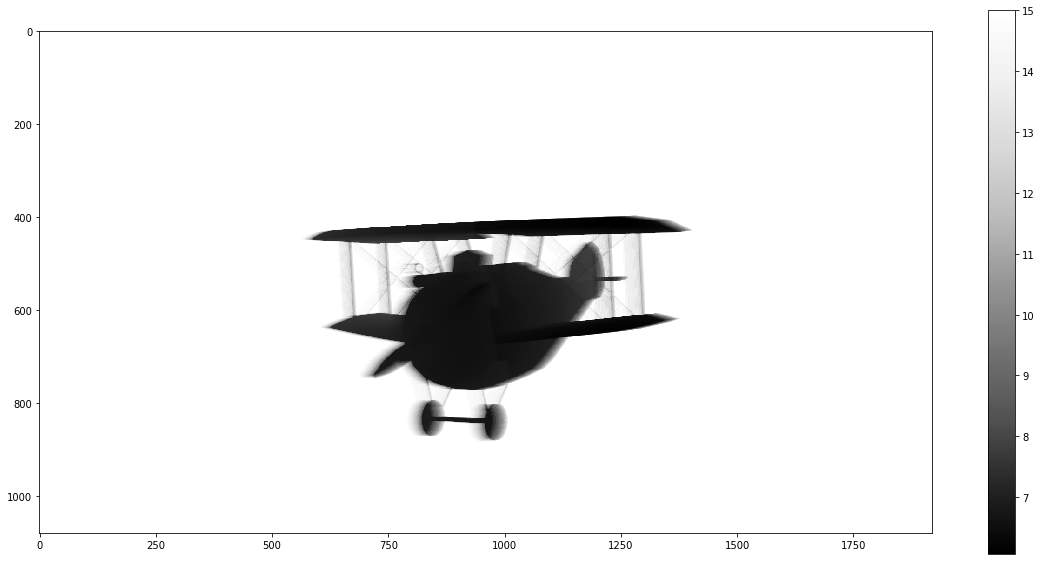









  3%|▎         | 1/30 [00:31<15:26, 31.96s/it]

dist between depth_first pic with motion blur and GT: 667979.7532378633
Correspondence set estimation...
Extrinsics estimation...


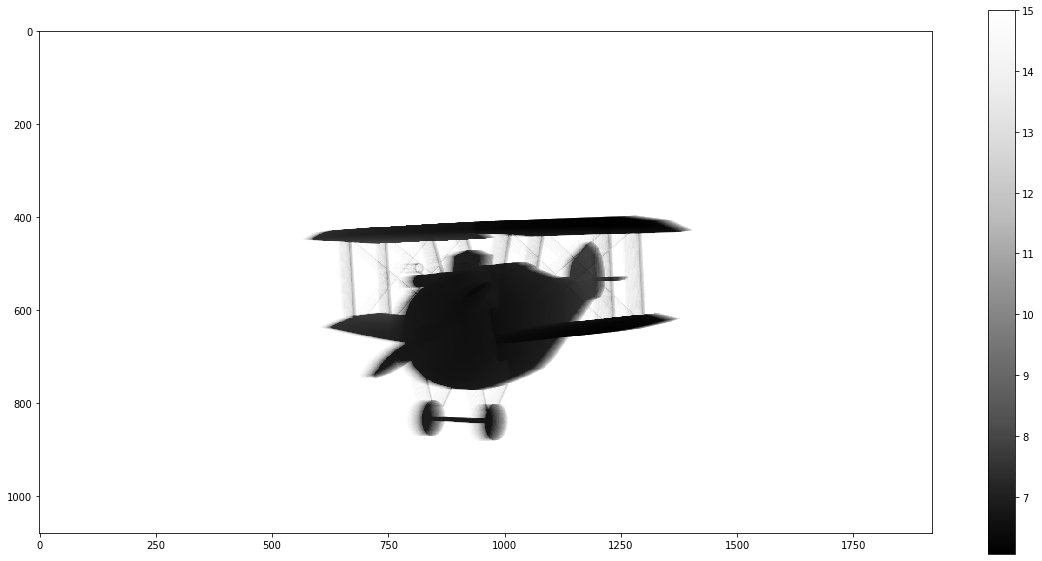









  7%|▋         | 2/30 [01:02<14:43, 31.55s/it]

dist between depth_first pic with motion blur and GT: 668189.6685552426
Correspondence set estimation...
Extrinsics estimation...


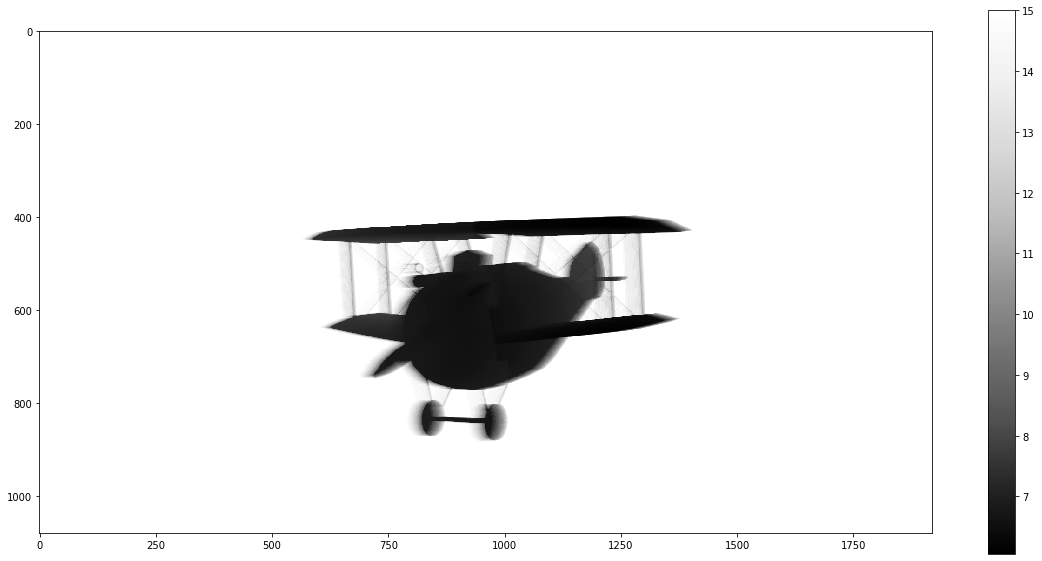









 10%|█         | 3/30 [01:34<14:15, 31.69s/it]

dist between depth_first pic with motion blur and GT: 668432.1745066777


In [ ]:
gradslam_iter = 30

opt = optim.Adam([depth_first], lr=1e-2)

depth_history = []
for i in tqdm(range(gradslam_iter)):
    pc0 = Cloud.from_tensors(depth_first, K, torch.eye(4), ignore='max')
    pc1 = Cloud.from_tensors(depth_second, K, torch.eye(4), ignore='max')
    
    #TODO do several iterations of this with small icp_max_iter:
    params = optim_step_ICP(pc0, pc1, max_iter=100, icp_max_iter=10)
    transl, angle = params.split([3, 3], dim=-1)
    rot = create_rot_from_angle(angle.unsqueeze(0)).squeeze(0)
    pc0.points = transform_pc(pc0.points, rot, transl).squeeze(1) 
    T = extrinsics_from_rot_transl(rot, transl)
    
    opt.zero_grad()
    loss_val = loss(T, extr[0], extr[1])
    loss_val.backward()
    opt.step()
    
#     if i % 5 == 0:
#         visualize_pcd(pc0, pc1)
    
    depth_first_img = depth_first.cpu().data.numpy()
    depth_first_img_gt = gt_depth[0].cpu().data.numpy()
    depth_history.append(depth_first_img)
    plt.figure(figsize=(20, 10))
    plt.imshow(depth_first_img, cmap=plt.cm.Greys_r)
    plt.colorbar()
    plt.show()
    print('dist between depth_first pic with motion blur and GT:', ((depth_first_img - depth_first_img_gt) ** 2).sum())